In [1]:
import os

import geopandas as gpd

from sqlalchemy import create_engine

user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

In [2]:
url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(url)


In [3]:
x, y = 334289.32, 390468.43  # coordinates in epsg 27700
buffer = 5000  # radius in [m]

sql = f'SELECT * FROM openroads_200803 WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'

df = gpd.read_postgis(sql, engine, geom_col='geometry')

<AxesSubplot:>

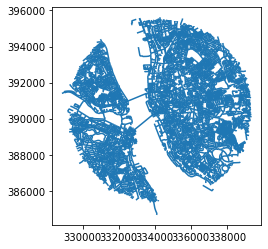

In [4]:
df.plot()

In [5]:
import keplergl

In [6]:
map_1 = keplergl.KeplerGl(height=800)
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(height=800)

In [7]:
map_1.add_data(data=df.to_crs(4326), name="openroads")

In [8]:
from consolidate import consolidate, roundabouts

In [16]:
cons = consolidate(df, filter_func=roundabouts, area=1000, circom=.75)

Merging segments: 100%|██████████| 949/949 [00:31<00:00, 30.54it/s]


In [24]:
map_1.add_data(data=points, name="pts_xy")

In [12]:
cons2 = consolidate(df, filter_func=roundabouts, area=500, circom=0)

Merging segments: 100%|██████████| 1209/1209 [00:45<00:00, 26.40it/s]


In [19]:
map_1.add_data(data=lines.to_crs(4326), name="mesh")

In [18]:
lines.columns

Index(['id', 'endNode', 'startNode', 'roadNumberTOID', 'roadNameTOID',
       'fictitious', 'roadClassification', 'roadFunction', 'formOfWay',
       'length', 'length_uom', 'loop', 'primaryRoute', 'trunkRoad',
       'roadClassificationNumber', 'name1', 'name1_lang', 'name2',
       'name2_lang', 'roadStructure', 'geometry', 'mm_len', 'meshedness'],
      dtype='object')

In [14]:
g = mm.gdf_to_nx(df)
g = mm.meshedness(g)

100%|██████████| 12160/12160 [00:25<00:00, 478.89it/s]


In [16]:
mm.mean_nodes(g, 'meshedness')

In [23]:
points = points.to_crs(4326)
points['x'] = points.geometry.x
points['y'] = points.geometry.y

Triangles are tricky, as they're

In [11]:
from itertools import combinations

import pygeos
import numpy as np
import pandas as pd
import geopandas as gpd
import momepy as mm  # this is only temporary to simplify the identification of incorrect polygons

from shapely.ops import polygonize
from scipy.spatial import Voronoi


# helper functions
def get_ids(x, ids):
    return ids[x]


mp = np.vectorize(get_ids, excluded=["ids"])


def dist(p1, p2):
    return np.sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))


def get_verts(x, voronoi_diagram):
    return voronoi_diagram.vertices[x]


def _average_geometry(lines, poly=None, distance=2):
    """
    Returns average geometry.


    Parameters
    ----------
    lines : list
        LineStrings connected at endpoints forming a closed polygon
    poly : shapely.geometry.Polygon
        polygon enclosed by `lines`
    distance : float
        distance for interpolation

    Returns list of averaged geometries
    """
    if not poly:
        polygons = list(polygonize(lines))
        if len(polygons) == 1:
            poly = polygons[0]
        else:
            raise ValueError("given lines do not form a single polygon")
    # get an additional line around the lines to avoid infinity issues with Voronoi
    extended_lines = [poly.buffer(distance).exterior] + lines

    # interpolate lines to represent them as points for Voronoi
    points = np.empty((0, 2))
    ids = []

    pygeos_lines = pygeos.from_shapely(extended_lines)
    lengths = pygeos.length(pygeos_lines)
    for ix, (line, length) in enumerate(zip(pygeos_lines, lengths)):
        pts = pygeos.line_interpolate_point(
            line, np.linspace(0.1, length - 0.1, num=int((length - 0.1) // distance))
        )  # .1 offset to keep a gap between two segments
        points = np.append(points, pygeos.get_coordinates(pts), axis=0)
        ids += [ix] * len(pts)

        # here we might also want to append original coordinates of each line
        # to get a higher precision on the corners, but it does not seem to be
        # necessary based on my tests.

    # generate Voronoi diagram
    voronoi_diagram = Voronoi(points)

    # get all rigdes and filter only those between the two lines
    pts = voronoi_diagram.ridge_points
    mapped = mp(pts, ids=ids)

    # iterate over segment-pairs
    edgelines = []
    for a, b in combinations(range(1, len(lines) + 1), 2):
        mask = (
            np.isin(mapped[:, 0], [a, b])
            & np.isin(mapped[:, 1], [a, b])
            & (mapped[:, 0] != mapped[:, 1])
        )
        rigde_vertices = np.array(voronoi_diagram.ridge_vertices)
        verts = rigde_vertices[mask]

        # generate the line in between the lines
        edgeline = pygeos.line_merge(
            pygeos.multilinestrings(get_verts(verts, voronoi_diagram))
        )
        snapped = pygeos.snap(edgeline, pygeos_lines[a], distance)
        edgelines.append(snapped)
    return edgelines


def consolidate(network, distance=2, epsilon=2, filter_func=None, **kwargs):
    """
    Consolidate edges of a network, takes care of geometry only. No
    attributes are preserved at the moment.

    The whole process is split into several steps:
    1. Polygonize network
    2. Find polygons which are likely caused by dual lines and other
       geometries to be consolidated.
    3. Iterate over those polygons and generate averaged geometry
    4. Remove invalid and merge together with new geometry.

    Step 2 needs work, this is just a first attempt based on shape and area
    of the polygon. We will have to come with clever options here and
    allow their specification, because each network will need different
    parameters.

    Either before or after these steps needs to be done node consolidation,
    but in a way which does not generate overlapping geometries.
    Overlapping geometries cause (unresolvable) issues with Voronoi.

    Parameters
    ----------
    network : GeoDataFrame (LineStrings)

    distance : float
        distance for interpolation

    epsilon : float
        tolerance for simplification

    filter_func : function
        function which takes gdf of polygonized network and returns mask of invalid
        polygons (those which should be consolidated)

    **kwargs
        Additional kwargs passed to filter_func
    """

    # polygonize network
    polygonized = polygonize(network.geometry)
    geoms = [g for g in polygonized]
    gdf = gpd.GeoDataFrame(geometry=geoms, crs=network.crs)

    # filter potentially incorrect polygons
    mask = filter_func(gdf, **kwargs)
    invalid = gdf.loc[mask].unary_union

    sindex = network.sindex

    # iterate over polygons which are marked to be consolidated
    # list segments to be removed and the averaged geoms replacing them
    averaged = []
    to_remove = []
    for poly in invalid.geoms:
        real = network.iloc[sindex.query(poly.exterior, predicate="intersects")]
        outline_mask = real.intersection(poly.exterior).type.isin(
            ["LineString", "MultiLineString"]
        )
        outline = real[outline_mask]
        lines = list(outline.geometry)
        remove_mask = real.intersection(poly).type.isin(
            ["LineString", "MultiLineString"]
        )
        to_remove += list(real[remove_mask].index)

        if lines:
            av = _average_geometry(lines, poly, distance)
            averaged += av

    # drop double lines
    clean = network.drop(set(to_remove))

    # merge new geometries with the existing network
    averaged = gpd.array.from_shapely(averaged, crs=network.crs).simplify(epsilon)
    result = pd.concat([clean, gpd.GeoDataFrame(geometry=averaged[~averaged.is_empty])])
    merge = mm.network_false_nodes(result)

    return merge


def roundabouts(gdf, area=5000, circom=0.6):
    """
    Filter out roundabouts
    """

    # calculate parameters
    gdf["area"] = gdf.geometry.area
    gdf["circom"] = mm.CircularCompactness(gdf, "area").series
    # select valid and invalid network-net_blocks
    mask = (gdf["area"] < area) & (gdf["circom"] > circom)
    return mask


def filter_comp(gdf, max_size=10000, circom_max=0.2):
    """
    Filter based on max size and compactness

    Parameters
    ----------
    gdf : GeoDataFrame
        polygonized network
    max_size : float
        maximum size of a polygon to be considered potentially invalid
    circom_max : float
        maximum circular compactness of a polygon to be considered
        potentially invalid.

    Returns boolean series

    """
    # calculate parameters
    gdf["area"] = gdf.geometry.area
    gdf["circom"] = mm.CircularCompactness(gdf, "area").series
    # select valid and invalid network-net_blocks
    mask = (gdf["area"] < max_size) & (gdf["circom"] < circom_max)
    return mask


In [34]:
df.geometry.interiors

0        None
1        None
2        None
3        None
4        None
         ... 
15599    None
15600    None
15601    None
15602    None
15603    None
Length: 15604, dtype: object

In [35]:
import warnings
warnings.filterwarnings('always')